# Project 2: Word Embeddings and the Brain
### Structured Task - Sentence decoding


In [ ]:
from google.colab import drive
import sys
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
from gensim.models import KeyedVectors
import os
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors
import matplotlib.pyplot as plt
import time
from google.colab import drive
import pickle
import pprint
from collections import defaultdict



## Data & Decoding

## part 1
Performing analysis of Homework Assignment 3 question 3 using another type of static word embeddings- Word2vec and compare the results to those you obtained with GloVe.

In [ ]:
drive.mount('/content/gdrive')
GDRIVE_DIR = "/content/gdrive/My Drive"

Mounted at /content/gdrive


In [ ]:
# downloads the GLoVe word embeddings and saves them to your Google drive.
!time wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p "$GDRIVE_DIR"
!mv glove.6B.300d.txt "$GDRIVE_DIR/"

# Download and extract the data and learn_decoder.py
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1xZaorRH-xxjfochvSesAhOTUg82_Xq56" -O files.zip && rm -rf /tmp/cookies.txt
!unzip files.zip
!rm files.zip
!gdown --folder https://drive.google.com/drive/folders/1gFIrqTvvi6wsowcN3U2iZiVDvEC3fuxq
!mv -v "Structured Task (sentence decoding)"/* ./

--2023-05-17 14:57:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-05-17 14:57:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-05-17 14:57:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
from learn_decoder import *

In [ ]:
data = pd.read_csv("neuralData_for_EXP1.csv")
vectors = read_matrix("vectors_180concepts.GV42B300.txt", sep=" ")
concepts = np.genfromtxt('stimuli_180concepts.txt', dtype=np.dtype('U'))

In [ ]:
google_model = KeyedVectors.load_word2vec_format(os.path.join(GDRIVE_DIR, "GoogleNews-vectors-negative300.bin.gz"), binary=True)

In [ ]:
np_data = data.to_numpy()
data = np_data[:,1:]
data = np.delete(data, 6, 0)
vectors = np.delete(vectors, 6, 0)
concepts = np.delete(concepts, 6)

### Functions

In [ ]:
def cosine_similarity(x: np.ndarray, y: np.ndarray) -> float:
    norm_x = np.dot(x, y)
    norm_y = np.linalg.norm(x)*np.linalg.norm(y)
    return norm_x / norm_y

In [ ]:
def train_decoder(train_data, train_vectors, decoder_func):
    decoder = decoder_func(train_data, train_vectors)
    return decoder

In [ ]:
def get_rank(predicted_vectors, true_vectors):
    ranks = {}
    for concept_index in range(predicted_vectors.shape[0]):
        closeness = {}
        predicted_vec = predicted_vectors[concept_index]
        for k in range(true_vectors.shape[0]):
            closeness[k] = cosine_similarity(predicted_vec, true_vectors[k])
        closeness = {k: v for k, v in sorted(closeness.items(), key=lambda item: item[1], reverse=True)}
        rank = list(closeness.keys()).index(concept_index) + 1
        ranks[concept_index] = rank
    return ranks

In [ ]:
def k_fold_cv(data, vectors, concepts, decoder_func, folds=18):
    data_folds = np.array_split(data, folds)
    vector_folds = np.array_split(vectors, folds)
    test_accuracy = []
    concept_ranks = {}
    decoding_times = []

    for i in range(len(data_folds)):
        test_data = data_folds[i]
        test_vectors = vector_folds[i]
        train_data = np.concatenate([data_folds[j] for j in range(len(data_folds)) if j != i])
        train_vectors = np.concatenate([vector_folds[j] for j in range(len(vector_folds)) if j != i])
        decoder = train_decoder(train_data, train_vectors, decoder_func)
        predicted_vectors = test_data @ decoder
        ranks = get_rank(predicted_vectors, vectors)
        for concept_index, rank in ranks.items():
            general_concept_index = i * 10 + concept_index
            concept_ranks[general_concept_index] = rank
        average_rank = sum(ranks.values()) / len(ranks.values())
        test_accuracy.append(average_rank)

    return test_accuracy, concept_ranks

In [ ]:
def comparison_plot(x, y, label_x, label_y, title, col1,col2):
  '''
  Creating a graph comparing 2 results
  '''
  N = 18
  ind = np.arange(N)
  plt.figure(figsize=(10,5))
  plt.bar(ind, x , 0.3, label=label_x,color=col1)
  plt.bar(ind + 0.3, y, 0.3, label=label_y,color=col2)
  plt.xlabel('Fold')
  plt.ylabel('Average Rank')
  plt.title(title)
  plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
  x_vals = list(range(1,19))
  plt.xticks(ind + 0.3 / 2, x_vals)
  plt.legend(loc='best')
  plt.show()

In [ ]:
def results_plot_aac(color_, retuls, title):
  N = 18
  ind = np.arange(N)
  plt.figure(figsize=(8,5))
  plt.bar(ind, retuls , 0.5,color=color_)
  x_vals = list(range(18))
  plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
  plt.xticks(x_vals)
  plt.xlabel('Fold Number')
  plt.ylabel('Average Accuracy Score')
  plt.title(title)
  plt.show()


#### GloVe results


In [ ]:
results_glove, concept_ranks_glove = k_fold_cv(data, vectors, concepts,learn_decoder)

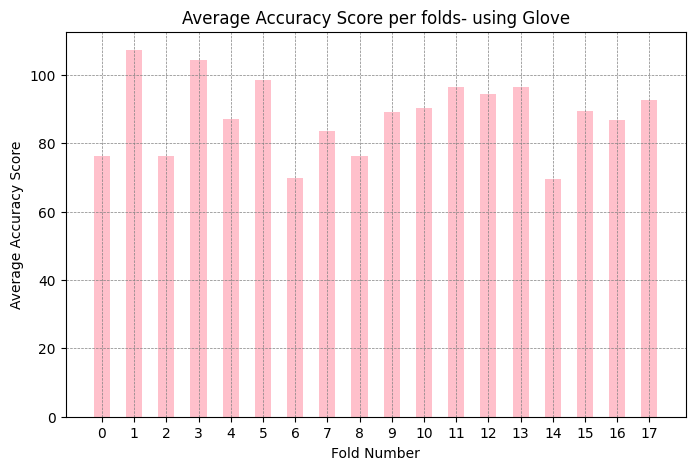

In [ ]:
results_plot_aac('pink',results_glove,'Average Accuracy Score per folds- using Glove')

#### word2vec results

In [ ]:
# save the words as word2vec using google modle
vectors_ = []
in_vocab = []
out_vocab = []
for concept in concepts:
  # get word2vec representation and save into vectors
  if concept in google_model:
    vectors_.append(google_model[concept])
    in_vocab.append(concept)
  else:
    out_vocab.append(concept)
vectors_ = np.array(vectors_)
# make sure that we have vector represntion for each word
print(vectors_.shape)
print(f'the number of out of vocabs is {len(out_vocab)}')

(179, 300)
the number of out of vocabs is 0


In [ ]:
# vectors_ = np.delete(vectors_, 6, 0)
results_word2vec, concept_ranks = k_fold_cv(data, vectors_, concepts,learn_decoder)

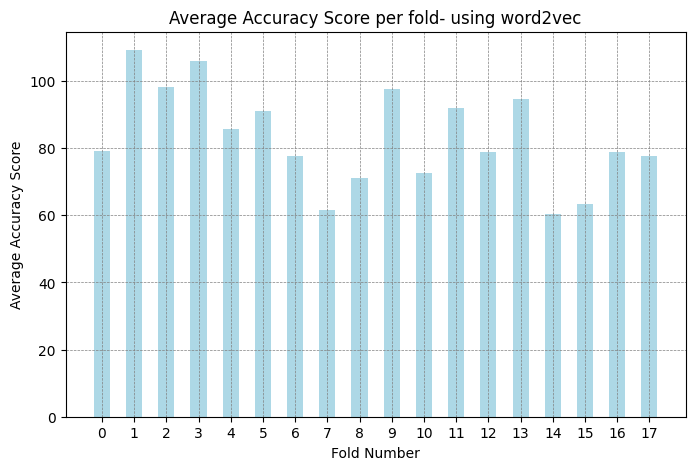

In [ ]:
# ploting the results
results_plot_aac('lightblue',results_word2vec,'Average Accuracy Score per fold- using word2vec')

### word2vec vs Glove















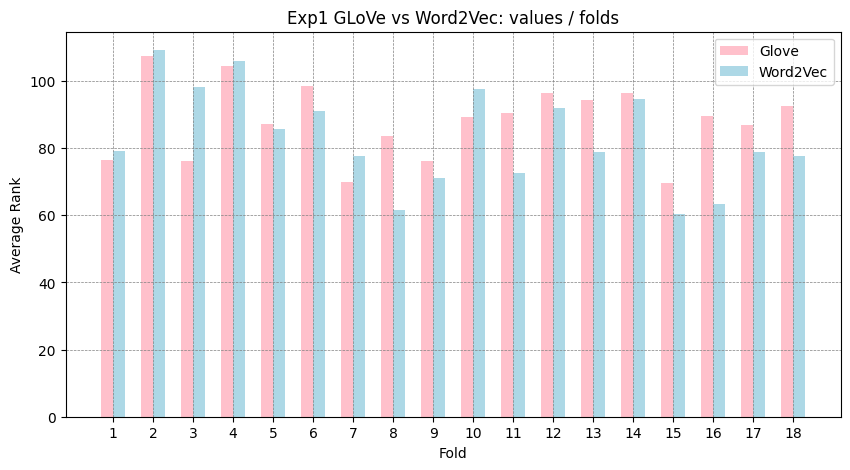

In [ ]:
comparison_plot(results_glove, results_word2vec, "Glove", "Word2Vec", "GLoVe vs Word2Vec: values / folds")

## Part 3

Use the GloVe based decoder model we trained in Homework Assignment 3 question 3
and test it on the datasets from analyses 2 & 3.

Each dataset contains sentence representations and the corresponding neural data from an individual subject. For each dataset, we used the learned decoder model to decode sentence representations and evaluate the performance via the rank accuracy method.

### Reading Data E2 & E3
uploading the relevant data and save it as dict

In [ ]:
# files 2
EXP2 = open ("EXP2.pkl", "rb")
EX2_dict = pickle.load(EXP2)
EXP2.close()
# files 3
EX3 = open ("EXP3.pkl", "rb")
EX3_dict = pickle.load(EX3)
EX3.close()

Dictionary basic information:

In [ ]:
print('Dict 2 keys:\n')
pprint.pprint(list(EX2_dict.keys()))
print('-------------------------------')
print('Dict 3 keys:\n')
pprint.pprint(list(EX3_dict.keys()))
print('dict shape:{}')

Dict 2 keys:

['__header__',
 '__version__',
 '__globals__',
 'keyPassageCategory',
 'keyPassages',
 'keySentences',
 'labelsPassageCategory',
 'labelsPassageForEachSentence',
 'labelsSentences',
 'meta',
 'Fmridata']
-------------------------------
Dict 3 keys:

['__header__',
 '__version__',
 '__globals__',
 'keyPassageCategory',
 'keyPassages',
 'keySentences',
 'labelsPassageCategory',
 'labelsPassageForEachSentence',
 'labelsSentences',
 'meta',
 'Fmridata']
dict shape:{}


#### Data decoding using GloVE

In [ ]:
exp2_data = EX2_dict["Fmridata"]
exp2_vectors = read_matrix("vectors_384sentences.GV42B300.average.txt", sep=" ")
exp2_sentencesfile = open("stimuli_384sentences.txt", "r")
exp2_concepts = np.asarray(exp2_sentencesfile.readlines())
exp2_sentencesfile.close()
print(f'EX2 vectors shape {exp2_vectors.shape}, and number of sentences={exp2_concepts.shape}')

EX2 vectors shape (384, 300), and number of sentences=(384,)


In [ ]:
exp3_data = EX3_dict["Fmridata"]
exp3_vectors = read_matrix("vectors_243sentences.GV42B300.average.txt", sep=" ")
exp3_sentencesfile = open("stimuli_243sentences.txt", "r")
exp3_concepts = np.asarray(exp3_sentencesfile.readlines())
exp3_sentencesfile.close()
print(f'EX3 vectors shape {exp3_vectors.shape}, and number of sentences={exp3_concepts.shape}')

EX3 vectors shape (243, 300), and number of sentences=(243,)


- EX3 contain 243 sentences , each represent by a vector size of 300
- EX2 contain 384 sentences , each represent by a vector size of 300

---



#### EX2 results

In [ ]:
results_ex2, concept_ranks_ex2 = k_fold_cv(exp2_data, exp2_vectors, exp2_concepts,learn_decoder)

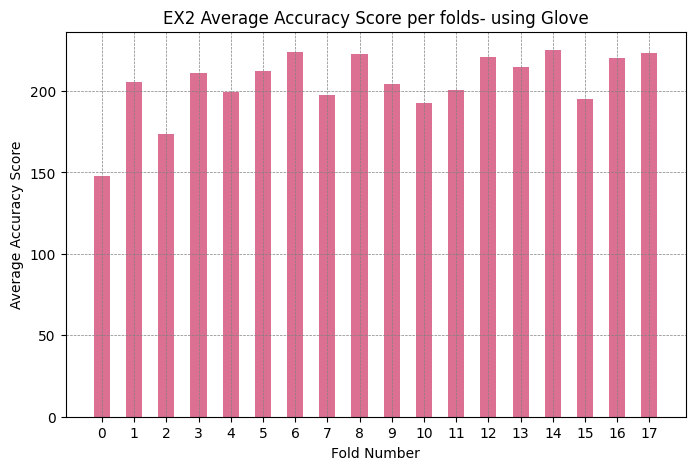

In [ ]:
# ploting the results
results_plot_aac('palevioletred',results_ex2,'EX2 Average Accuracy Score per folds- using Glove')

#### EX3 results

In [ ]:
results_ex3, concept_ranks_ex3 = k_fold_cv(exp3_data, exp3_vectors, exp3_concepts,learn_decoder)

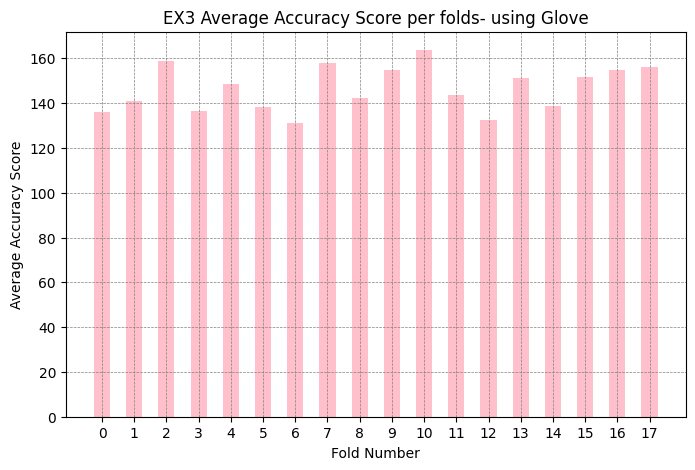

In [ ]:
# ploting the results
results_plot_aac('pink',results_ex3,'EX3 Average Accuracy Score per folds- using Glove')

  #### Compering EX2 vs EX3

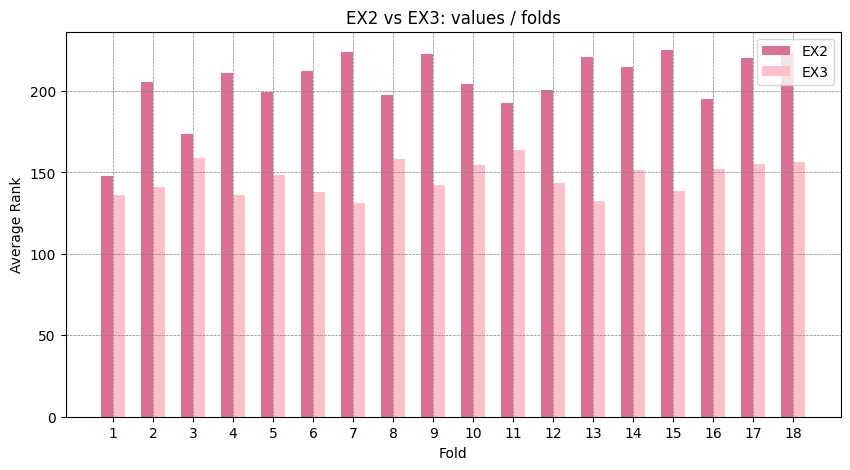

In [ ]:
comparison_plot(results_ex2, results_ex3, "EX2", "EX3", "EX2 vs EX3: values / folds")

Compering EX2 vs EX3 vs EX1

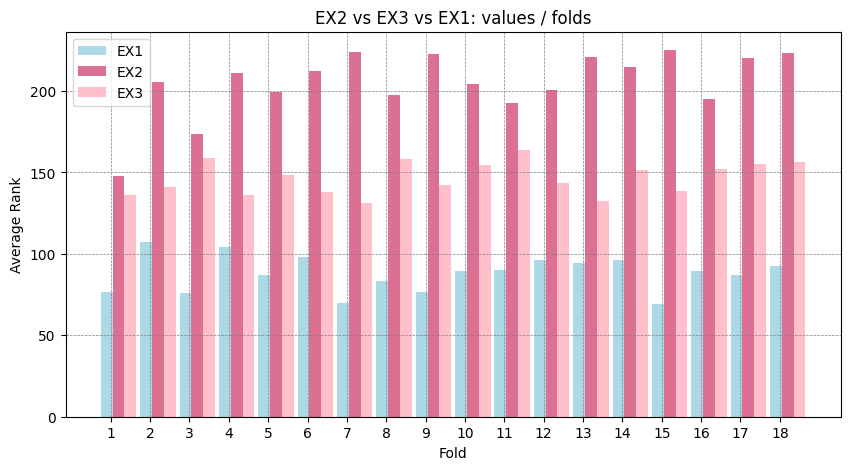

In [ ]:
N = 18
ind = np.arange(N)
plt.figure(figsize=(10,5))
plt.bar(ind , results_glove, 0.3, label='EX1',color='lightblue')
plt.bar(ind+0.3, results_ex2 , 0.3, label='EX2',color='palevioletred')
plt.bar(ind + 0.6, results_ex3, 0.3, label='EX3',color='pink')
plt.xlabel('Fold')
plt.ylabel('Average Rank')
plt.title('EX2 vs EX3 vs EX1: values / folds')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
x_vals = list(range(1,19))
plt.xticks(ind + 0.3 / 3, x_vals)
plt.legend(loc='best')
plt.show()

In general, we can see from the results that EX2's rank accuracy is higher than the rank accuracy of EX3.

## Part 4

Each sentence is related to a specific passage, and every passage is related to a specific broad topic.

In this part we will analyze the accuracy scores from the previous section and try to identify the topics where the decoder was more / less successful in predicting the sentences.

In [ ]:
def extract_unique(dict_):
  '''
  Extracts unique values ​​from the desired data
  '''
  res=[]
  for i in dict_:
      res.append(i[0])
  return res

In [ ]:
def extract_unique_2(dict_):
  '''
  Extracts unique values ​from the desired data
  '''
  res=[]
  for i in dict_:
      res_tep= i[0]
      res.append(res_tep[0])
  return (res)

In [ ]:
def Passage_Category(dict_i,res_KPC,res_KP):
  '''
  Stores in the dictionary the unique keys and the
  categories included under each key
  '''
  Passage_Category_dict = defaultdict(list)
  for i, id_list in enumerate(dict_i):
    topic = res_KPC[id_list[0]-1]
    passage = res_KP[i]
    Passage_Category_dict[topic].append(passage)
  return Passage_Category_dict

In [ ]:
def extract_sentence_key(exp_sentencesfile,dict_,res_KP,res_p_c):
  '''
  Saves pairs of sentences + labeling in the dictionary
  return: dictionary
  '''
  sentence_key = {}
  for i, sentence in enumerate(exp_sentencesfile):
    passage = res_KP[dict_["labelsPassageForEachSentence"][i][0] - 1]
    returned_topic = None
    for topic, p in res_p_c.items():
        if passage in p:
          returned_topic = topic
    sentence_key[sentence] = returned_topic
  return sentence_key

In [ ]:
def ranking(exp_concepts,concept_ranks_ex):
  words_rank = {exp_concepts[index]: rank for index, rank in concept_ranks_ex.items()}
  return words_rank

In [ ]:
def topic_rank(exp_concepts,concept_ranks_ex,res_sentence_key):
  '''
  Each sentence is related to a specific passage, and every passage is related to a specific broad topic .
  analyze the accuracy scores from the previous section and try to identify the topics where the decoder was more / less
  successful in predicting the sentences.
  '''
  topic_ranks = defaultdict(list)
  words_rank=ranking(exp_concepts,concept_ranks_ex)
  for sentence, rank in words_rank.items():
    topic = res_sentence_key[sentence]
    topic_ranks[topic].append(rank)

  topic_avg_rank = {topic: sum(topic_ranks[topic]) / len(topic_ranks[topic]) for topic in topic_ranks.keys()}
  topic_avg_rank_list = [(key, val) for key, val in topic_avg_rank.items()]
  topic_avg_rank_list = sorted(topic_avg_rank_list, key=lambda x: x[1])
  return topic_avg_rank_list

In [ ]:
def extracting_rank_plot(res_topic_avg_rank_list,color_,name):
  topic=[]
  rank=[]
  N =len(res_topic_avg_rank_list)
  for i in range(N):
    topic.append(res_topic_avg_rank_list[i][0])
    rank.append(res_topic_avg_rank_list[i][1])

  plt.figure(figsize=(8,5))
  plt.bar(topic, rank , 0.5,color=color_)
  plt.xticks(rotation=90)
  plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
  plt.xlabel('topic')
  plt.axhline(y=np.mean(rank), color='blue', linestyle='--', linewidth=2, label='Avg')
  plt.axhline(y=np.median(rank), color='green', linestyle='--', linewidth=2, label='Median')
  plt.legend(loc='best')
  plt.ylabel('Average Accuracy Score')
  plt.title(name)
  plt.show()

### calculations

using the functions defined above for EX2 & EX3

In [ ]:
#--------------------------------ex2--------------------------------------------
res_2_KPC=extract_unique(EX2_dict['keyPassageCategory'][0])
res_2_KP =extract_unique_2(EX2_dict['keyPassages'])
res_2_p_c =Passage_Category(EX2_dict["labelsPassageCategory"],res_2_KPC,res_2_KP) # פסקה
res_2_sentence_key =extract_sentence_key(exp2_concepts,EX2_dict,res_2_KP,res_2_p_c)
res_2_topic_avg_rank_list =topic_rank(exp2_concepts,concept_ranks_ex2,res_2_sentence_key)

#--------------------------------ex3--------------------------------------------
res_3_KPC=extract_unique(EX3_dict['keyPassageCategory'][0])
res_3_KP =extract_unique_2(EX3_dict['keyPassages'])
res_3_p_c =Passage_Category(EX3_dict["labelsPassageCategory"],res_3_KPC,res_3_KP)
res_3_sentence_key =extract_sentence_key(exp3_concepts,EX3_dict,res_3_KP,res_3_p_c)
res_3_topic_avg_rank_list =topic_rank(exp3_concepts,concept_ranks_ex3,res_3_sentence_key)

## ploting the results

Extracting data

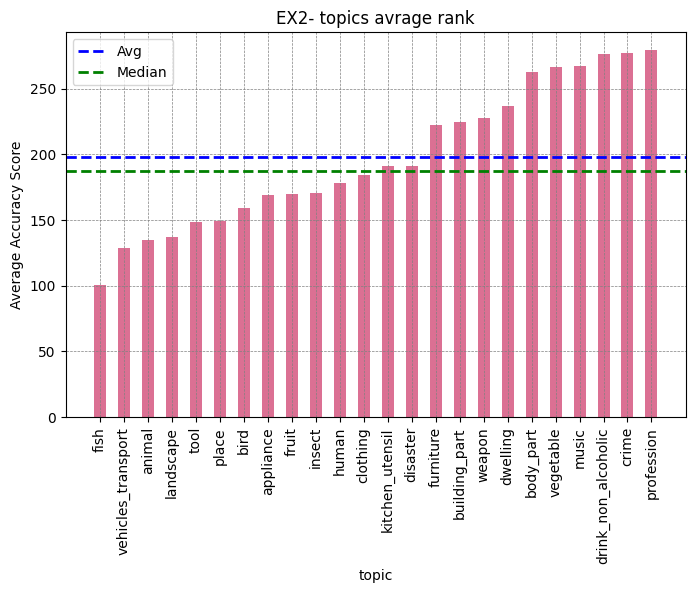

In [ ]:
# ploting EX2 results
extracting_rank_plot(res_2_topic_avg_rank_list,'palevioletred','EX2- topics avrage rank')

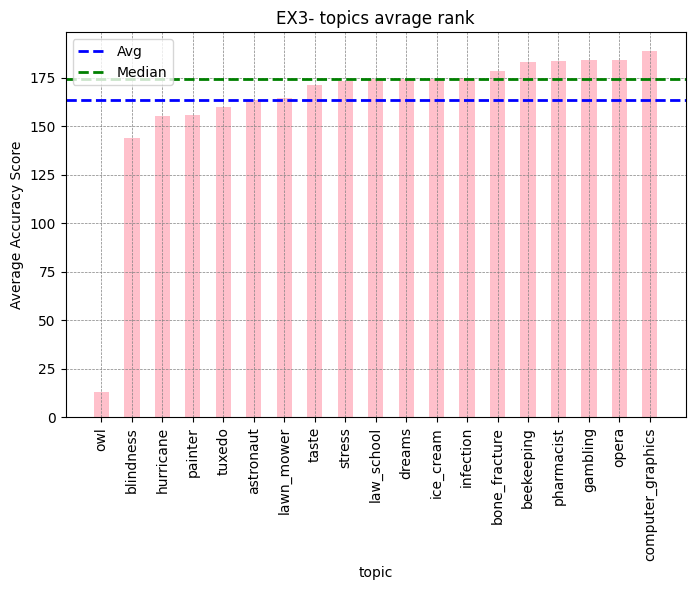

In [ ]:
# ploting EX3 results
extracting_rank_plot(res_3_topic_avg_rank_list,'pink','EX3- topics avrage rank')